# KITTI correspondences

## Prepare datasets

In [2]:
%reload_ext autoreload
%autoreload 2

import sys
import numpy as np
np.set_printoptions(precision=4, suppress=True)

KITTI_PATH = '/home/ruizhu/Documents/Datasets/kitti/raw'

sys.path.append(KITTI_PATH+'/kitti-lidar-utils')
sys.path.append(KITTI_PATH+'/kitti-lidar-utils/source')
sys.path.append(KITTI_PATH+'/depth/devkit/python')
# print(sys.path)
import itertools
import pdb
import pykitti  # install using pip install pykitti
import os
from PIL import Image, ImageOps
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from mayavi import mlab
# mlab.init_notebook() # http://docs.enthought.com/mayavi/mayavi/tips.html
# mlab.options.offscreen = True
# from imayavi import *
import time
from source.utils import load_tracklets_for_frames, point_inside, in_hull
from source import parseTrackletXML as xmlParser
from source.kitti_util import *
import argparse
from matplotlib import cm
from cluster_pcs.filters import *
from math import atan2, degrees
# from plyfile import PlyData, PlyElement
from PIL import Image
from read_depth import *
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Select sequence
date_name = '2011_09_26'
seq_name = '_drive_0005_sync'
tracklet_path = KITTI_PATH+'/%s/%s/tracklet_labels.xml'%(date_name, date_name+seq_name)
fdir_path = KITTI_PATH+'/%s/%s/'%(date_name, date_name+seq_name)
if os.path.exists(tracklet_path):
    print('======Tracklet Exists:', tracklet_path)
else:
    print('======Tracklet NOT Exists:', tracklet_path)
    
## Raw Data directory information
path = fdir_path.rstrip('/')
basedir = path.rsplit('/',2)[0]
date = path.split('/')[-2]
drive = path.split('/')[-1].split('_')[-2]

dataset = pykitti.raw(basedir, date, drive)
tracklet_rects, tracklet_types, tracklet_ids, tracklet_Rs, tracklet_ts = load_tracklets_for_frames(len(list(dataset.velo)),\
               '{}/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(basedir,date, date, drive))
# print(tracklet_Rs[0][0].shape, tracklet_ts[0][0].shape)
dataset_gray = list(dataset.gray)
dataset_rgb = list(dataset.rgb) 

======Tracklet Exists: /home/ruizhu/Documents/Datasets/kitti/raw/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml
Parsing tracklet file /home/ruizhu/Documents/Datasets/kitti/raw/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml
File contains 15 tracklets
Loaded 15 tracklets.


## Get camera in binocular setting

In [3]:
## From Rui
# Understanding calibs: https://github.com/utiasSTARS/pykitti/blob/0e5fd7fefa7cd10bbdfb5bd131bb58481d481116/pykitti/raw.py#L150
cam = 'leftRGB'
P_rects = {'leftRGB':dataset.calib.P_rect_20, 'rightRGB':dataset.calib.P_rect_30} # cameras def.: https://github.com/utiasSTARS/pykitti/blob/19d29b665ac4787a10306bbbbf8831181b38eb38/pykitti/odometry.py#L42
cam2cam = {}
R_cam2rect = dataset.calib.R_rect_00 # [cam0] R_rect_xx: 3x3 rectifying rotation to make image planes co-planar
P_rect = P_rects['leftRGB'] # P_rect_0[0-3]: 3x4 projection matrix after rectification; the reprojection matrix in MV3D
velo2cam = dataset.calib.T_cam0_velo_unrect
P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam) # 4*3

# Compute cam2 to cam 3 (pure translation)
print(dataset.calib.P_rect_20)
# print(dataset.calib.P_rect_30)
A = dataset.calib.P_rect_20[:, 0:3]
b = dataset.calib.P_rect_20[:, 3:4] - dataset.calib.P_rect_30[:, 3:4]
t = np.linalg.solve(A, b)
T = np.eye(4)
T[0:3, 3:4] = t
print(T)
print(np.matmul(dataset.calib.P_rect_30, T)) # should equal dataset.calib.P_rect_30

[[721.5377   0.     609.5593  44.8573]
 [  0.     721.5377 172.854    0.2164]
 [  0.       0.       1.       0.0027]]
[[ 1.      0.      0.      0.5327]
 [ 0.      1.      0.     -0.0028]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]]
[[721.5377   0.     609.5593  44.8573]
 [  0.     721.5377 172.854    0.2164]
 [  0.       0.       1.       0.0027]]


# Sample of binocular images and projections

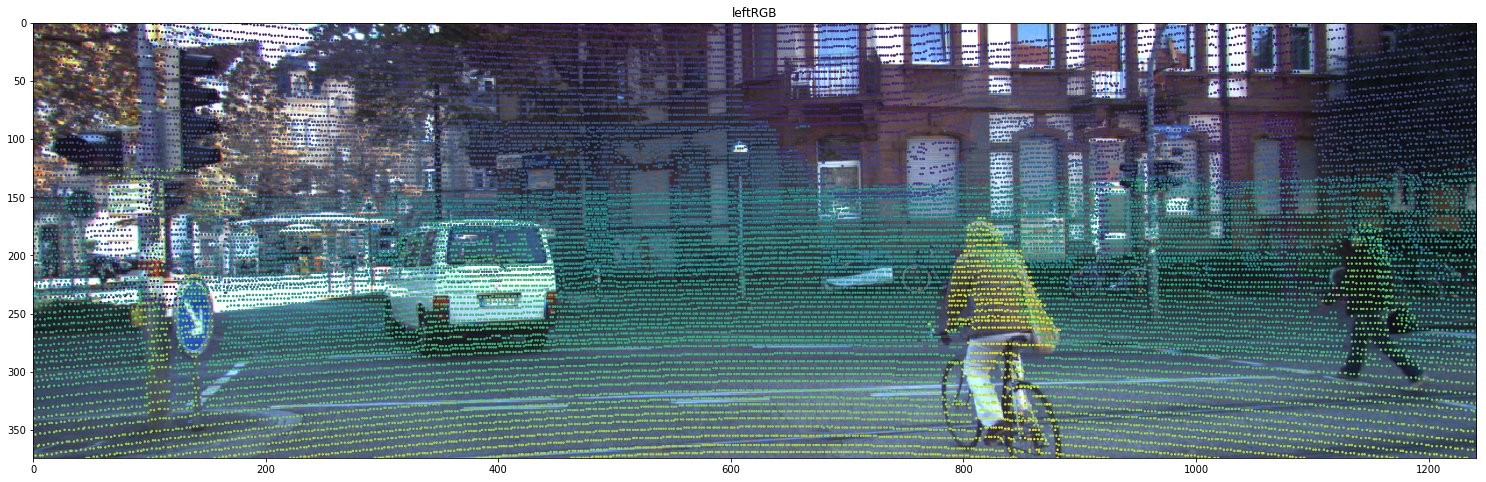

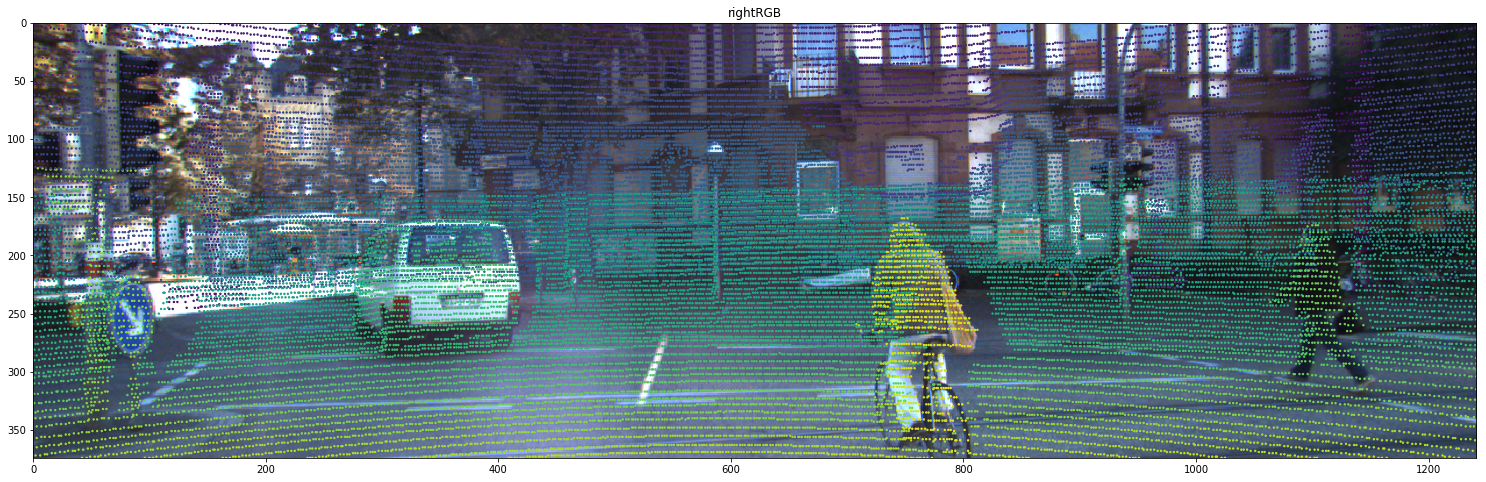

In [180]:
def xyz_to_hom(xyzs):
    # xysz: 3*N
    return np.vstack((xyzs, np.ones((1, xyzs.shape[1]))))

fig_scale = 300
fig_ratio = [4, 3]

velo_pts_im_list = []

for i,velo in enumerate(dataset.velo):
    ## Plot 3: Projection
#     vel_depth = True
    im_shape = [375, 1242]
    # project the points to the camera
    # Filter points inside bbox
    velo_reproj = velo[:, :3]
    velo_reproj = np.hstack((velo_reproj, np.ones((velo_reproj.shape[0], 1))))
    
    for cam_iter, cam in enumerate(['leftRGB', 'rightRGB']):
        P_rect = P_rects[cam] # P_rect_0[0-3]: 3x4 projection matrix after rectification; the reprojection matrix in MV3D
        P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam) # 4*3
        
        velo_pts_im = np.dot(P_velo2im, velo_reproj.T).T # [*, 3]
        velo_pts_im[:, :2] = velo_pts_im[:,:2] / velo_pts_im[:,2][..., np.newaxis]
    #     if vel_depth: # Use velo first dimmension as depth
    #         velo_pts_im[:, 2] = velo_reproj[:, 0]
        
        velo_pts_im_list.append(velo_pts_im.copy())
        
        # check if in bounds
        # use minus 1 to get the exact same value as KITTI matlab code
        velo_pts_im[:, 0] = np.round(velo_pts_im[:,0]) - 1
        velo_pts_im[:, 1] = np.round(velo_pts_im[:,1]) - 1
        val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
        val_inds = val_inds & (velo_pts_im[:,0] < im_shape[1]) & (velo_pts_im[:,1] < im_shape[0])
        velo_pts_im = velo_pts_im[val_inds, :]

        plt.figure(figsize=(30, 8))
        plt.imshow(dataset_rgb[i][cam_iter])
        plt.scatter(velo_pts_im[:, 0].astype(np.int), velo_pts_im[:, 1].astype(np.int), s=2, c=1./velo_pts_im[:, 2])
        plt.xlim(0, im_shape[1]-1)
        plt.ylim(im_shape[0]-1, 0)
        plt.title(cam)
        plt.show()

    #     if i > 1:
    break

## Epipolar constriants and solving for E and F

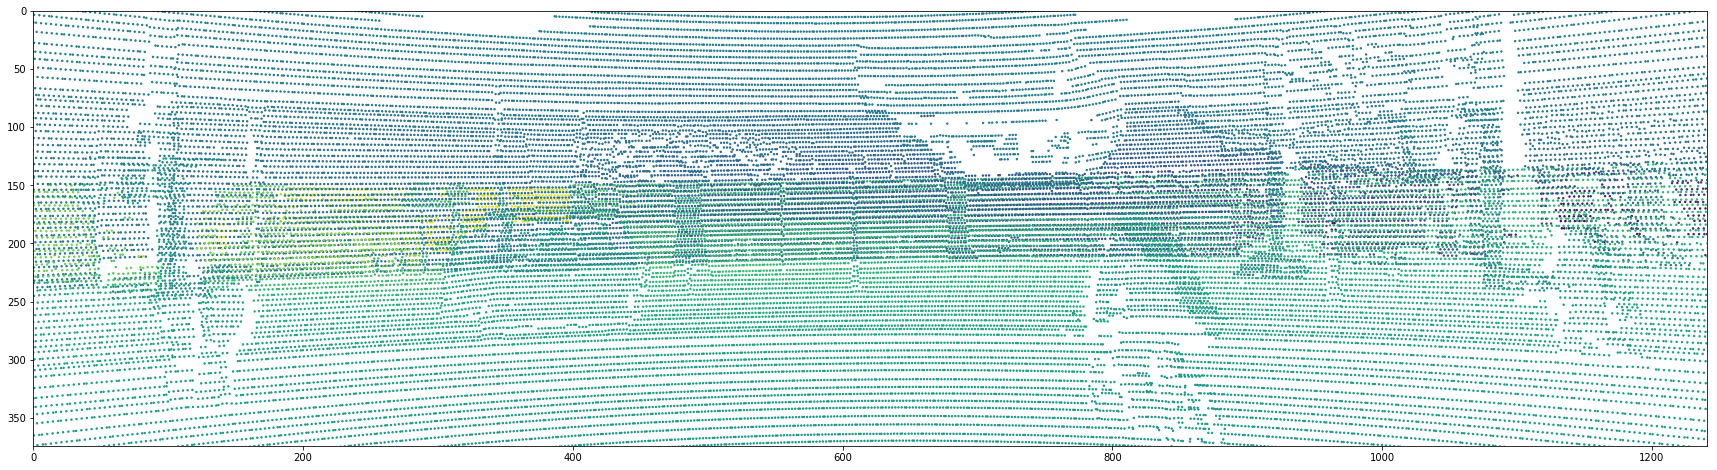

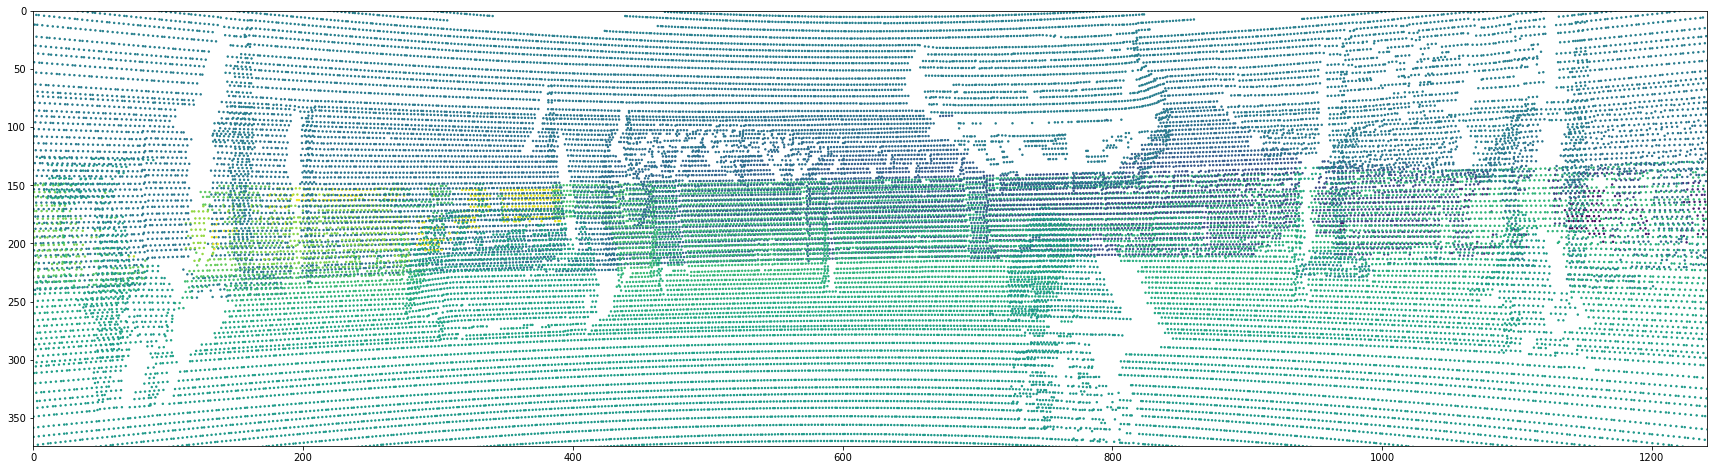

[[ 0.         -0.08958824 -0.0596804  ... -0.13425568 -0.00009057
  -0.10829429]
 [ 0.08958785 -0.00000001  0.02990776 ... -0.04466399  0.08949701
  -0.01870574]
 [ 0.05968042 -0.02990791  0.         ... -0.07457322  0.05958967
  -0.04861383]
 ...
 [ 0.13425541  0.04466406  0.07457303 ... -0.00000001  0.1341644
   0.02595774]
 [ 0.00009054 -0.08949739 -0.05958964 ... -0.13416466  0.
  -0.10820338]
 [ 0.10829413  0.01870577  0.04861373 ... -0.02595776  0.1082032
  -0.00000001]]
torch.Size([4, 1000])
XwX shape = torch.Size([9, 9])
[[ 0.53271193]
 [-0.0027529 ]
 [ 0.00001598]]
---- [[ 0.         -0.00001598 -0.0027529 ]
 [ 0.00001598  0.         -0.5327119 ]
 [ 0.0027529   0.5327119   0.        ]]
- [[-0.         -0.00000002 -0.002749  ]
 [ 0.00000002 -0.         -0.53271196]
 [ 0.002749    0.53271196 -0.        ]]
---- [[ 0.         -0.         -0.00000381]
 [ 0.          0.         -0.00073832]
 [ 0.00000381  0.00073832  0.        ]]
- [[ 0.          0.          0.00000381]
 [-0.       

In [250]:
import torch

# https://github.com/vcg-uvic/learned-correspondence-release/blob/16bef8a0293c042c0bd42f067d7597b8e84ef51a/network.py#L160
def torch_skew_symmetric(v): # v: [3, 1]
    zero = torch.zeros_like(v[0, 0])
    M = torch.stack([
        zero, -v[2, 0], v[1, 0],
        v[2, 0], zero, -v[0, 0],
        -v[1, 0], v[0, 0], zero,
    ], dim=0)
    return torch.reshape(M, (3, 3))

def scatter_xy(xy, c, im_shape):
    plt.figure(figsize=(30, 8))
    plt.scatter(xy[:, 0], xy[:, 1], s=2, c=c)
    plt.xlim(0, im_shape[1]-1)
    plt.ylim(im_shape[0]-1, 0)
    plt.show()
    val_inds = (xy[:, 0] >= 0) & (xy[:, 1] >= 0)
    val_inds = val_inds & (xy[:,0] < im_shape[1]) & (xy[:,1] < im_shape[0])
    return val_inds

def homo_py(x):
    # input: x [N, 2]
    # output: x_homo [N, 3]
    N = list(x.size())[0]
    x_homo = torch.cat((x, torch.ones(N, 1)), 1)
    return x_homo

def de_homo_py(x_homo):
    # input: x_homo [N, 3]
    # output: x [N, 2]
    N = list(x_homo.size())[0]
    epi = 1e-10
    x = torch.cat((x_homo[:, 0:1]/(x_homo[:, 2:3]+epi), x_homo[:, 1:2]/(x_homo[:, 2:3]+epi)), 1)
    return x

val_inds_list = []
for idx in range(2):
    val_inds = scatter_xy(velo_pts_im_list[idx], velo_pts_im_list[idx][:, 2], im_shape)
    val_inds_list.append(val_inds)

np.set_printoptions(precision=8, suppress=True)

t_x = torch_skew_symmetric(torch.from_numpy(t).float())
E = torch.matmul(t_x, torch.eye(3))
K = torch.from_numpy(dataset.calib.P_rect_20[:3, :3]).float()

import random
random.seed(10)
val_inds_both = val_inds_list[0] & val_inds_list[1]
val_idxes = [idx for idx in range(velo_pts_im_list[0].shape[0]) if val_inds_both[idx]]
random_idx= random.sample(val_idxes, 1000)

# Verify the epipolar constraint
xy1_random = torch.from_numpy(velo_pts_im_list[0][random_idx, 0:2])
xy2_random = torch.from_numpy(velo_pts_im_list[1][random_idx, 0:2])
xy1_homo = homo_py(xy1_random.float())
xy2_homo = homo_py(xy2_random.float())
# should_zeros = torch.matmul(torch.matmul(xy2_homo, E), xy1_homo.t()).numpy()
F = torch.matmul(torch.matmul(torch.inverse(K).t(), E), torch.inverse(K))
should_zeros = torch.matmul(torch.matmul(xy2_homo, F), xy1_homo.t()).numpy()
print(should_zeros)

# Solve E
## Create the matrix to be used for the eight-point algorithm
xx = torch.cat([xy1_random.t(), xy2_random.t()], dim=0)
print(xx.size())
X = torch.stack([
    xx[2, :] * xx[0, :], xx[2, :] * xx[1, :], xx[2, :],
    xx[3, :] * xx[0, :], xx[3, :] * xx[1, :], xx[3, :],
    xx[0, :], xx[1, :], torch.ones_like(xx[0, :])
], dim=0).t()
XwX = torch.matmul(X.t(), X)
print("XwX shape = {}".format(XwX.shape))

# Recover essential matrix from self-adjoing eigen
e, v = torch.eig(XwX, eigenvectors=True)
print(t)
print('----', E.numpy())
E_recover = v[:, 8].reshape((3, 3))
E_recover = E_recover / torch.norm(E_recover) * torch.norm(E)
print('-', E_recover.numpy())

# Recover F
print('----', F.numpy())
U, D, V = torch.svd(X)
F_recover = torch.reshape(V[:, -1], (3, 3))
F_recover_rescale = F_recover / torch.norm(F_recover) * torch.norm(F)
print('-', F_recover_rescale.numpy())
FU, FD, FV= torch.svd(F_recover);
FDnew = torch.diag(FD);
FDnew[2, 2] = 0;
F_recover_sing = torch.mm(FU, torch.mm(FDnew, FV.t()))
F_recover_sing_rescale = F_recover_sing / torch.norm(F_recover_sing) * torch.norm(F)
print('-', F_recover_sing_rescale.numpy())